In [1]:
import numpy as np
import os
import sys
sys.path.append('./scripts')
from joblib import load
import proplot as plot
from normalise_pdf import normalise_pdf
from ecs_cdf import ecs_cdf

In [2]:
def kernel_smooth(bin_centres, y, bin_width):
  # apply Gausian Kernel smoothing to y
  # JDA uses sd of 0.1
  kernel_sd = 0.1

  smoothed_y = np.copy(y)

  # apply kernel filter over central range
  istart = int(n_bins / 2 - 4000)
  iend = int(n_bins / 2 + 4000)

  smooth = True
  if smooth:
    for i in range(istart,iend):
      x = bin_centres[i]
      k = np.exp(-1*( x - bin_centres ) ** 2 / (2 * kernel_sd ** 2))
      smoothed_y[i] = np.sum(y * k)
  smoothed_y = normalise_pdf(smoothed_y, bin_width)

  return(smoothed_y)


dumpfile = ./data/sherwood/ULI_MEDIUM_SAMPLE/ULI_MEDIUM_SAMPLE.lastmean.joblib
dumpfile = ./data/sherwood/ULI_MEDIUM_SAMPLE/ULI_MEDIUM_SAMPLE.lastpartial.joblib
color = k
bin_width =  0.010000000000005116
Prior;P(ECS <1);P(ECS <1.5);P(ECS <2);P(ECS >4);P(ECS >4.5);P(ECS >6);          P(1.5 -4.5);5th pile;10th pile;17th pile;20th pile;25th pile;50th pile;          75th pile;80th pile;83rd pile;90th pile;95th pile;Mode;Mean
qlabel= Loopsum Posterior 2.134455051472788e-08 0.0011400465194740651 0.9008765567530027 14.607897363290576 6.822307620084729 0.7666723083356572 93.17655233339579 2.2550000000000026 2.4050000000000082 2.5549999999999997 2.615000000000002 2.6950000000000003 3.105000000000011 3.625000000000007 3.7850000000000037 3.884999999999998 4.2350000000000065 4.695 2.884999999999998 3.248716914966606
histogram total 0.9999999999999893
cdf= 0.9999999999999893
median and 5-95% range for Loopsum Posterior:       3.11       2.26 -       4.70
ecs17 = 2.5549999999999997
ecs83 = 3.884999

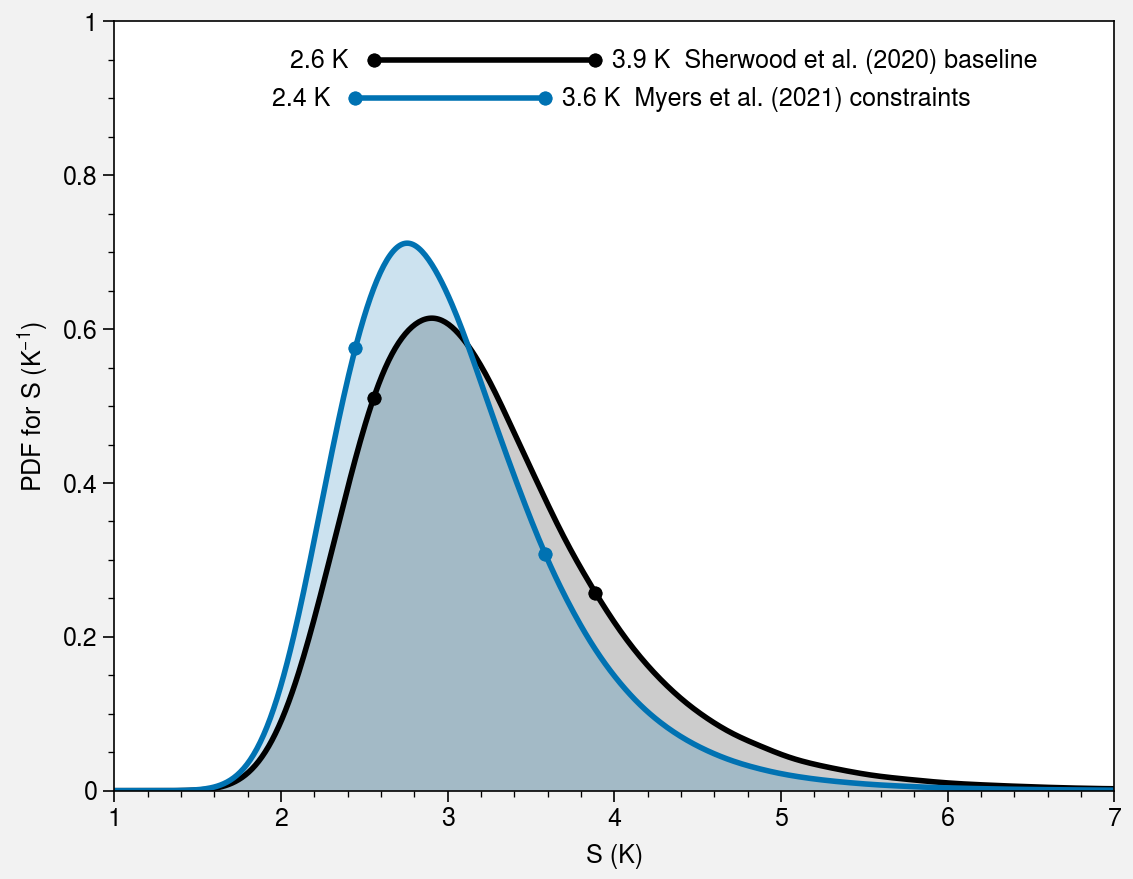

In [3]:
P = os.path.join
fig_dir = 'figs'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

out_dt = './data'

fig, ax = plot.subplots(ncols=1, aspect=1.3, axwidth=5)
ax.format(xlabel='S (K)', ylabel='PDF for S $(K^{-1})$',
        xlim=[1,7], ylim=[0,1], grid=False)

colors=['k', 'C0']
labels = ['Sherwood et al. (2020) baseline', 'Myers et al. (2021) constraints']
calc_id = "ULI_MEDIUM_SAMPLE"
ref_papers = ['sherwood', 'myers']

for j, ref_paper in enumerate(ref_papers):
    dt_dir = P(out_dt, ref_paper, calc_id)

    dumpfile= P(dt_dir, calc_id + '.lastmean.joblib')
    print('dumpfile =', dumpfile)
    [transfer_unweighted_prior_pdf, transfer_weighted_prior_pdf,
      total_hist_erf_posterior, total_hist_erf_prior, ecs_pdf, posterior,
      n_bins, bin_boundaries, bin_centres, bin_width, n_samples,
      s_pdf, s_prior_pdf, full_l_prior_pdf, l_process_bu_likelihood,
      l_process_ec_likelihood, l_hist_likelihood, l_paleo_cold_likelihood,
      l_paleo_hot_likelihood, l_prior, l_posterior, s_process_bu_likelihood,
      s_process_ec_likelihood, s_hist_likelihood, s_paleo_cold_likelihood,
      s_paleo_hot_likelihood, full_s_prior_pdf] = load(dumpfile)

    dumpfile=P(dt_dir, calc_id + '.lastpartial.joblib')
    print('dumpfile =', dumpfile)
    [toploop_index, transfer_unweighted_prior_pdf_sum,
      transfer_weighted_prior_pdf_sum, total_hist_erf_posterior_sum,
      total_hist_erf_prior_sum,ecs_pdf_sum,s_pdf_sum, s_prior_pdf_sum,
      full_l_prior_pdf_sum, l_process_bu_likelihood_sum,
      l_process_ec_likelihood_sum, l_hist_likelihood_sum,
      l_paleo_cold_likelihood_sum, l_paleo_hot_likelihood_sum,
      l_prior_sum, l_posterior_sum, s_process_bu_likelihood_sum,
      s_process_ec_likelihood_sum, s_hist_likelihood_sum,
      s_paleo_cold_likelihood_sum, s_paleo_hot_likelihood_sum,
      full_s_prior_pdf_sum] = load(dumpfile)

    posterior = normalise_pdf(posterior, bin_width)

    label = labels[j]
    color = colors[j]
    print("color =", color)

    # apply Gausian Kernel smoothing to posterior
    smoothed_posterior = kernel_smooth(bin_centres, posterior, bin_width)
    linewidth=2
    ax.plot(bin_centres, smoothed_posterior, color, linewidth=linewidth)
    ax.fill_between(bin_centres, 0, smoothed_posterior, color=color, alpha=0.2)

    [p_ecs_lt_1p5, p_ecs_gt_4p5, ecs5,ecs17, ecs83, ecs95, ecs_mean, ecs_mode] =\
      ecs_cdf(posterior,bin_boundaries,bin_width,'Loopsum Posterior')

    markersize=4

    # plot ecs66:
    i17 = int((ecs17 - bin_boundaries[0]) / bin_width)
    ax.plot([ecs17, ecs17], [smoothed_posterior[i17], smoothed_posterior[i17]],
            color, marker='o', markersize=markersize)

    i83 = int((ecs83 - bin_boundaries[0]) / bin_width)
    ax.plot([ecs83,ecs83],[smoothed_posterior[i83], smoothed_posterior[i83]],
              color, marker='o', markersize=markersize)
    if 'sherwood' in ref_paper:
      yloc = 0.95
    else:
      yloc = 0.9
    ax.plot([ecs17, ecs83], [yloc, yloc], color=color, linewidth=2) # label=label
    # ax.plot([ecs17, ecs17], [0, yloc], '--', color=color)
    # ax.plot([ecs83, ecs83], [0, yloc], '--', color=color)
    for xloc in [ecs17, ecs83]:
      ax.plot([xloc, xloc], [yloc, yloc], color, marker='o', markersize=markersize)

    ax.text(ecs17 - 0.5, yloc - 0.01, '%.1f K' % ecs17)
    ax.text(ecs83 + 0.1, yloc - 0.01, '%.1f K  ' % ecs83 + label)

    np.savetxt(P(out_dt, "bin_boundaries.csv"), bin_boundaries, delimiter=",")
    np.savetxt(P(out_dt, "bin_centres.csv"), bin_centres, delimiter=",")
    np.savetxt(P(out_dt, calc_id + ".csv"), smoothed_posterior, delimiter=",")

    print('ecs17 =', ecs17)
    print('ecs83 =', ecs83)

fig_name = P(fig_dir, 'myers2021_fig5.png')
fig.savefig(fig_name, bbox_inches="tight", pad_inches=0.1, transparent=False)
#plt.savefig(fig_name.replace('.png', '.eps'), ,bbox_inches="tight", pad_inches=0.1)